## Code and Documentation to Decode Popup Buoy Transmitted/Recorded Data

## Data Structure

Data downloaded from Popup Buoy's directly, generate 8 binary files.  A complete description of these files can be found at **[link]**.  Relevant pieces will be included in the notebook.

Filenames:
- BOTDAT.TXT
- FILEPOS.TXT
- ICEDAT.TXT
- JPGxxxxx.JPG
- PRODAT.TXT
- SSTDAT.TXT
- SUMMARY.TXT

In [192]:
instfile_dic = {'bot_file': 'sampledata/BOTDAT.TXT',
                'ice_file': 'sampledata/ICEDAT.TXT',
                'pro_file': 'sampledata/PRODAT.TXT',
                'sst_file': 'sampledata/SSTDAT.TXT'}

For each data file, we are going to read in the entire file and convert the binary to hex.  There are multiple line, lengths we are going to have to address but the start of each record is denoted by 'FFFF'.  We can split the filestring on this parameter but we need to be aware of 'FFFFF' or 'FFFFFF' posibilities

***Basic Approach***

The two modules below will allow for a simple readin of the file for very simple analysis and debugging... the code of consequence that involves conversion of measurements from engineering units to science units as all defined in the PopUpBuoy CLASS in the next section

In [193]:
def HexView(file):
    with open(file, 'rb') as in_file:
        while True:
            hexdata = in_file.read().hex().upper()     # Read the shortest possible line
            if len(hexdata) == 0:                      # breaks loop once no more binary data is read
                break
            
            return(hexdata.upper())
        
def HexSplit(hexstr):
    if hexstr.find('FFFFF') == -1:
        print("No FFFFF, proceed to split on FFFF")
        sample_raw = hexstr.split('FFFF')[1:]
    else:
        print('FFFFF found')
        #this puts in the proper line endings but removes a variable 
        #   F from the end of each string.  Add the F string back
        sample_raw = []
        for substr in hexstr.split('FFFFF')[1:]: 
            sample_raw = sample_raw + (substr + 'F').split('FFFF')

        sample_raw[-1] = sample_raw[-1][:-1]
        
    return(sample_raw)

In [194]:
active_file = instfile_dic['bot_file']

hexstr = HexView(active_file)
sample_raw = HexSplit(hexstr)


No FFFFF, proceed to split on FFFF


# Class description and routine code

## Decode sample data for each file type

### Bottom Data (BOTDAT.TXT) / Under Ice Data (ICEDAT.TXT)

This data has two record lengths.  17 and 19.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 15 and 17 (which is a string length of 30 and 34 characters)

***MSG Decode Key***
![BotDecodeMsg](decode_images/BotDat_msg_decode.png)

***Engineering to Science Conversions***
![BotDecodeMsg](decode_images/BotDat_msg_cal.png)


### Profile Data (PRODAT.TXT) /

This data has two record lengths.  13 and 15.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 11 and 13 (which is a string length of 26 and 30 characters).  This file does not have the bottom temp or the reference temp fields.

***MSG Decode Key***
![ProDecodeMsg](decode_images/ProDat_msg_decode.png)

***Engineering to Science Conversions***
![ProCalMsg](decode_images/ProDat_msg_cal.png)

### SST Data (SSTDAT.TXT) /

This data has four record lengths.  17 and 35 or 19 and 37.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 15 and 33 or 17 and 35.  The 4 times of files are if there is the short time format or the long time format and if there is gps encoding or not for each of the time formats.

17: short-time, no gps
19: long-time, no gps
35: short-time, gps
37: long-time, gps

***MSG Decode Key***
![SSTDecodeMsg](decode_images/SSTDat_msg_decode.png)

***Engineering to Science Conversions***
![SSTDecodeMsg](decode_images/SSTDat_msg_cal.png)

### Defining the PopUpBuoy Class

In [13]:
import numpy as np
import pandas as pd
import yaml

def signed_int(hexstr):
    '''function to convert hex string to signed int'''
    s_int = int(hexstr,16)
    if s_int >= 0x8000:
        s_int -= 0x10000  

    return(s_int)

class PopUpBuoys(object):
    """Class definitions to read and Process PopUp Buoy Data Streams"""


    active_stream = 'bottom'
    def __init__(self, path):
        self.path = path
        self.instfile_dic = {'bottom': path + '/BOTDAT.TXT',
                             'ice': path + '/ICEDAT.TXT',
                             'profile': path + '/PRODAT.TXT',
                             'sst': path + '/SSTDAT.TXT'}
    
    def LoadCoefs(self, config_file='default.yaml'):
        ''' Load yaml formated config file '''
        self.config = yaml.safe_load(open(config_file))

    
    def HexView(self, active_stream='', verbose=True):
        '''
        input: reference to proper filepointer, options are keys 
            to the self.instfile_dic dictionary
        '''
        if active_stream:
            self.active_stream = active_stream
            
        file = self.instfile_dic[self.active_stream]
        with open(file, 'rb') as in_file:
            while True:
                hexdata = in_file.read().hex().upper()     
                if len(hexdata) == 0:                      
                # breaks loop once no more binary data is read
                    break
                self.hexstr = hexdata.upper()
                
                if verbose:
                    return(hexdata.upper())

    def HexSplit(self, verbose=True):
        '''
        input: results of HexView (inherits output)
        '''
        if self.hexstr.find('FFFFF') == -1:
            print("No FFFFF, proceed to split on FFFF")
            #because in this case the first index is empty
            sample_raw = self.hexstr.split('FFFF')[1:] 
        else:
            print('FFFFF found')
            #this puts in the proper line endings but removes a variable 
            #   F from the end of each string.  Add the F string back
            sample_raw = []
            for substr in self.hexstr.split('FFFFF'): 
                sample_raw = sample_raw + (substr + 'F').split('FFFF')

            sample_raw[-1] = sample_raw[-1][:-1]
        
        self.sample_raw = sample_raw
        
        if verbose:
            return(sample_raw)
    
    def Bottom(self, asPandas=False):
        ''' Bottom is equivalent to the TimeSeriesBase'''
        
        if self.active_stream != 'bottom':
            print("current active file is {} - can't output bottom data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()

        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    

    def Profile(self, asPandas=False):
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
            return

        if self.active_stream != 'profile':
            print("current active file is {} - can't output profile data".format(self.active_stream))
            return
                        
        data={}

        for sample_num, sample in enumerate(self.sample_raw):
                        
            if len(sample) == 22: #2byte timeword
                
                # unlike sst, bottom, and ice - profiles don't need to be multiplied by a sample interval
                #seconds since 1970-01-01
                try:
                    time = int(sample[0:4],16)/100 + profile_starttime
                except:
                    time = int(sample[0:4],16)/100 + 0
                    
                pressure =  self.PressureConversion(int(sample[4:8],16)) 
                
                topside_temp_ADC = signed_int(sample[8:12])
                topside_temp = self.TempConversion(engr_meas=topside_temp_ADC,
                                                  coefA=self.config['topside_temp_cal']['Acoef'], 
                                                  coefB=self.config['topside_temp_cal']['Bcoef'],
                                                  coefC=self.config['topside_temp_cal']['Ccoef'])

                rawpvalue = signed_int(sample[12:16])                  
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])   

                rawfvalue = signed_int(sample[16:20])                   
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[20:22],16) #degrees
                
            elif len(sample) == 26: #4byte timeword, reserved for profile starttime
                
                #seconds since 1970-01-01
                profile_starttime = int(sample[0:8],16)
                
                time = profile_starttime
                
                pressure =  self.PressureConversion(int(sample[8:12],16))  
                
                topside_temp_ADC = signed_int(sample[12:16])
                topside_temp = self.TempConversion(engr_meas=topside_temp_ADC,
                                                  coefA=self.config['topside_temp_cal']['Acoef'], 
                                                  coefB=self.config['topside_temp_cal']['Bcoef'],
                                                  coefC=self.config['topside_temp_cal']['Ccoef'])
                
                rawpvalue = signed_int(sample[16:20])             
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])  

                rawfvalue = signed_int(sample[20:24])                
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[24:26],16) #degrees
            
            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'topside_temp':topside_temp,
                                'topside_temp_ADC':topside_temp_ADC,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}        
        
        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
        
    def Ice(self, asPandas=False):
        ''' Ice is equivalent to the TimeSeriesBase'''

        if self.active_stream != 'ice':
            print("current active file is {} - can't output ice data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()

        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    
    def SST(self, asPandas=False):
        ''' SST is equivalent to the TimeSeriesBase + GPS information'''
        
        if self.active_stream != 'sst':
            print("current active file is {} - can't output sst data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()


        for sample_num, sample in enumerate(self.sample_raw):
            
            if (len(sample) == 30) or (len(sample) == 66): #2byte timeword, no TTS (w and w/o gps)
                TTS = np.nan
                if len(sample) == 66:
                    gps_data = self.GPSSeriesBase()
                else:
                    gps_data = self.GPSSeriesBase(empty=True)

            elif (len(sample) == 32) or (len(sample) == 68): #2byte timeword, yes TTS (w and w/o gps)
                TTS = int(sample[30:32],16)
                if len(sample) == 68:
                    gps_data = self.GPSSeriesBase(offset=2)
                else:
                    gps_data = self.GPSSeriesBase(empty=True)

            elif (len(sample) == 34) or (len(sample) == 70): #4byte timeword, no TTS (w and w/o gps)
                TTS = np.nan
                if len(sample) == 70:
                    gps_data = self.GPSSeriesBase(offset=4)
                else:
                    gps_data = self.GPSSeriesBase(empty=True)

            elif (len(sample) == 36) or (len(sample) == 72): #4byte timeword, yes TTS (w and w/o gps)
                TTS = int(sample[30:32],16)
                if len(sample) == 72:
                    gps_data = self.GPSSeriesBase(offset=6)
                else:
                    gps_data = self.GPSSeriesBase(empty=True)

            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num].update({'TTS':TTS})        
            data[sample_num].update(gps_data[sample_num])
        
        if asPandas:
            return(pd.DataFrame.from_dict(data,orient='index'))
        else:
            return(data)


    ### The folowing BASE functions are for convenience for reading and coding.  All redundant
    # pattern reads are below.  The only challenge is that each BASE function reads the entire hex
    # string (non-issue for files of size we expect)
    def GPSSeriesBase(self, offset=0, empty=True):
        '''SST only, the last 18 bytes are the same format:
         GPSLat, GPSLon, GPSDate, GPSTime, TTF, Max_Tilt
         Regardless of whether TTS or longdates are used.  This subroutine returns the 
         GPS dictionary based on a byte offset given the record length

         Passing empty=True sends missing data back for GPS Data'''
        data={}

        for sample_num, sample in enumerate(self.sample_raw):

            if not empty:
                GPSLat = int(sample[30+offset:38+offset],16)/1000000
                GPSLon = int(sample[38+offset:46+offset],16)/1000000
                GPSDate = int(sample[46+offset:54+offset],16)
                GPSTime = int(sample[54+offset:62+offset],16)
                TTF = int(sample[62+offset:64+offset],16)
                Max_Tilt = int(sample[62+offset:66+offset],16)     
            else:
                GPSLat = GPSLon = GPSDate = GPSTime = TTF = Max_Tilt = np.nan 

            #save to dictionary
            data[sample_num] = {'GPSLat':GPSLat,
                                'GPSLon':GPSLon,
                                'GPSDate':GPSDate,
                                'GPSTime':GPSTime,
                                'TTF':TTF,
                                'Max_Tilt':Max_Tilt}  
            
        return(data)   

    def TimeSeriesBase(self):
        '''Bottom, Ice, and SST all have the same base transmission information,
            e.g. the first 17 bytes (short time stamp) / 19 bytes (long time stamp)
            are the same.  Each of the the appropriate modules will call this communal module
            first.

            Bottom and Ice don't report any additional information beyond the base info so 
            they are essential decorators/wrappers for this function

            Returns: Dictionary'''
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
            return

        data={}

        for sample_num, sample in enumerate(self.sample_raw):
            
            #record length conditionals are due to number of varying outputs
            #SST dominates the number of options due to:
            # 2byte timeword, no TTS, no GPS (30)
            # 4byte timeword, yes TTS, yes GPS (72)
            #  and every permutation of the three functions
            if ((len(sample) == 30) or (len(sample) == 32) or 
                            (len(sample) == 60) or (len(sample) == 64)) : #2byte timeword
                
                #seconds since 1970-01-01
                time = int(sample[0:4],16) * self.config['sample_interval'][self.active_stream] 
                
                pressure =  self.PressureConversion(int(sample[4:8],16))  
                
                topside_temp_ADC = signed_int(sample[8:12])
                topside_temp = self.TempConversion(engr_meas=topside_temp_ADC,
                                                  coefA=self.config['topside_temp_cal']['Acoef'], 
                                                  coefB=self.config['topside_temp_cal']['Bcoef'],
                                                  coefC=self.config['topside_temp_cal']['Ccoef'])

                underside_temp_ADC = signed_int(sample[12:16])
                underside_temp = self.TempConversion(engr_meas=underside_temp_ADC,
                                                  coefA=self.config['underside_temp_cal']['Acoef'], 
                                                  coefB=self.config['underside_temp_cal']['Bcoef'],
                                                  coefC=self.config['underside_temp_cal']['Ccoef'])

                temp_ref = signed_int(sample[16:20])               
                
                rawpvalue = signed_int(sample[20:24])               
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope']) 
                
                rawfvalue = signed_int(sample[24:28])                 
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[28:30],16) #degrees
                
            elif ((len(sample) == 34) or (len(sample) == 36) or 
                              (len(sample) == 68) or (len(sample) == 72)) : #4byte timeword
                
                #seconds since 1970-01-01
                time = int(sample[0:8],16)
                
                pressure =  self.PressureConversion(int(sample[8:12],16))   
                
                topside_temp_ADC = signed_int(sample[12:16])
                topside_temp = self.TempConversion(engr_meas=topside_temp_ADC,
                                                  coefA=self.config['topside_temp_cal']['Acoef'], 
                                                  coefB=self.config['topside_temp_cal']['Bcoef'],
                                                  coefC=self.config['topside_temp_cal']['Ccoef'])

                underside_temp_ADC = signed_int(sample[16:20])
                underside_temp = self.TempConversion(engr_meas=underside_temp_ADC,
                                                  coefA=self.config['underside_temp_cal']['Acoef'], 
                                                  coefB=self.config['underside_temp_cal']['Bcoef'],
                                                  coefC=self.config['underside_temp_cal']['Ccoef'])

                temp_ref = signed_int(sample[20:24])          
                
                rawpvalue = signed_int(sample[24:28])                 
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])  

                rawfvalue = signed_int(sample[28:32])               
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  
                
                tilt = int(sample[32:34],16) #degrees            

            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'topside_temp':topside_temp,
                                'topside_temp_ADC':topside_temp_ADC,
                                'underside_temp':underside_temp,
                                'underside_temp_ADC':underside_temp_ADC,
                                'temp_ref':temp_ref,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}  
        return(data)

    @staticmethod
    def PARConversion(engr_meas,coef_offset, coef_slope):
        ''' Calculate PAR from raw measurement
        
            (ADC_val - coef_offset) * coef_slope / 0.73

            output is PAR in umolm-2s-1
        '''
        return((engr_meas - coef_offset) * coef_slope / 0.73 )

    @staticmethod
    def FluorConversion(engr_meas,coef_offset, coef_slope):
        ''' Calculate Fluometer from raw measurement

            (ADC_val - coef_offset) * coef_slope
        
            output is concentration in ug/L
        '''
        return((engr_meas - coef_offset) * coef_slope) 

    @staticmethod
    def PressureConversion(engr_meas):
        ''' Calculate Pressure from raw measurement

            (ADC_val - 16384) * 10 / 32768
        
            output is Pressure in Bars
        '''
        return((engr_meas - 16384) * 10 / 32768)

    @staticmethod
    def TempConversion(engr_meas, coefA, coefB, coefC):
        ''' Calculate Temperature from raw measurement.

        1 / ( coefA + 
              coefB*np.log10(ADC_val) + 
              coefC*np.log10(ADC_val)^3 ) - 273.15 

        Output is Temperature in DegC
        '''
        temperature = 1 / ( coefA + 
                     coefB*np.log10(engr_meas) + 
                     coefC*np.log10(engr_meas)**3 ) - 273.15        

        return(temperature)        



## Sample Evaluation of routine

Imagine a buoy with ID number 119087.  Instantiate a PopUpBuoys class with the relative (or absolute) path to the location of the download/reconstructed data files

In [14]:
IDNUMBER = PopUpBuoys('sampledata')

Load the configuration file.  If not specified it will load a file named 'default.yaml' in the same path as the utility

In [15]:
IDNUMBER.LoadCoefs()

Call the routine to read and convert the binary file to a hex string... the sample parameter is the name of the data type.

active_stream options are:
+ bottom
+ sst
+ profile
+ ice

passing 'verbose=True' returns the hex string

In [16]:
IDNUMBER.HexView(active_stream='bottom',verbose=True)

'FFFF000049BE298E2960214E1D30005907FFFF000149C0296C2944214F1A2C004A07FFFF000249C029502933214F18AC003D07FFFF000349C229452931214F17A0003D07FFFF000449C3294A293B214F15F0004507FFFF000549C429542949214F1558004307FFFF000649C629612957214F1552004207FFFF000749C529682962214F1552003407FFFF000849C72975296F214F1552003707FFFF000949C929842980214F1552003607FFFF000A49C92993298F214F1552002F07FFFF000B49CA29A329A0214F1552004C07FFFF000C49CA29B329B0214F1552003D07FFFF000D49CA29BE29BD214F1552003807FFFF000E49CB29CC29CB214F1552002E07FFFF000F49CC29D729D5214F1552003E07FFFF001049CD29E329E2214F15C0003A07'

In [17]:
IDNUMBER.HexSplit(verbose=True)

No FFFFF, proceed to split on FFFF


['000049BE298E2960214E1D30005907',
 '000149C0296C2944214F1A2C004A07',
 '000249C029502933214F18AC003D07',
 '000349C229452931214F17A0003D07',
 '000449C3294A293B214F15F0004507',
 '000549C429542949214F1558004307',
 '000649C629612957214F1552004207',
 '000749C529682962214F1552003407',
 '000849C72975296F214F1552003707',
 '000949C929842980214F1552003607',
 '000A49C92993298F214F1552002F07',
 '000B49CA29A329A0214F1552004C07',
 '000C49CA29B329B0214F1552003D07',
 '000D49CA29BE29BD214F1552003807',
 '000E49CB29CC29CB214F1552002E07',
 '000F49CC29D729D5214F1552003E07',
 '001049CD29E329E2214F15C0003A07']

In [18]:
bottom_data = IDNUMBER.Bottom(asPandas=True)

In [19]:
bottom_data

,time,pressure,topside_temp,topside_temp_ADC,underside_temp,underside_temp_ADC,temp_ref,par,fluor,tilt
0,0,0.761108,20.005236,10638,20.118637,10592,8526,39.038493,1.025105,7
1,3600,0.761719,20.076017,10604,20.177135,10564,8527,24.074384,0.711297,7
2,7200,0.761719,20.134499,10576,20.212737,10547,8527,16.631096,0.439331,7
3,10800,0.762329,20.157521,10565,20.216930,10545,8527,11.436301,0.439331,7
4,14400,0.762634,20.147053,10570,20.195975,10555,8527,3.062603,0.606695,7
5,18000,0.762939,20.126133,10580,20.166676,10569,8527,0.116301,0.564854,7
6,21600,0.763550,20.098971,10593,20.137421,10583,8527,0.000000,0.543933,7
7,25200,0.763245,20.084360,10600,20.114465,10594,8527,0.000000,0.251046,7
8,28800,0.763855,20.057256,10613,20.087370,10607,8527,0.000000,0.313808,7
9,32400,0.764465,20.026027,10628,20.051994,10624,8527,0.000000,0.292887,7


In [20]:
IDNUMBER.HexView(active_stream='ice',verbose=False)
IDNUMBER.HexSplit(verbose=False)
ice_data = IDNUMBER.Ice(asPandas=True)

No FFFFF, proceed to split on FFFF


In [21]:
IDNUMBER.HexSplit(verbose=True)


No FFFFF, proceed to split on FFFF


['0003407D294B297C214F578B00510D',
 '0004407C290E2950214F7037003A0E',
 '0005407C286A292E214F7A38004B0E',
 '0006407A290B2918214F3B1700490D',
 '0007407A28FA2911214F2944004C0D',
 '0008407A28EB28FB214F202200370D',
 '0009407A290228FF214F1AE800450E',
 '000A407A29032904214F158800380E',
 '000B407C290E290A214F155200360D',
 '000C407C290C290E214F155200420E',
 '000D407F29122914214F155200300D',
 '000E407F291B291B214F155200360D',
 '000F407F29262925214F155200430E',
 '00104080292C292A214F155200340E',
 '0011408229362936214F1552003A0E',
 '0012408229482948214F155200410E',
 '001340822959295A214F155200370E',
 '00144084297A2971214F1553002C0E',
 '0015408529832985214F16D5003E0E',
 '0016408729862992214F214500320E',
 '0017405220F8296C214F55EE004D10']

In [22]:
IDNUMBER.Ice(asPandas=True)

,time,pressure,topside_temp,topside_temp_ADC,underside_temp,underside_temp_ADC,temp_ref,par,fluor,tilt
0,10800,0.038147,20.144960,10571,20.060312,10620,8527,328.609521,0.857741,13
1,14400,0.037842,20.273042,10510,20.152043,10576,8527,451.036096,0.376569,14
2,18000,0.037842,20.621583,10346,20.223221,10542,8527,500.677397,0.732218,14
3,21600,0.037231,20.279362,10507,20.269415,10520,8527,187.419658,0.690377,13
4,25200,0.037231,20.315218,10490,20.284136,10513,8527,98.972466,0.753138,13
5,28800,0.037231,20.346909,10475,20.330473,10491,8527,53.653699,0.313808,13
6,32400,0.037231,20.298336,10498,20.322040,10495,8527,27.718493,0.606695,14
7,36000,0.037231,20.296227,10499,20.311504,10500,8527,1.046712,0.334728,14
8,39600,0.037842,20.273042,10510,20.298868,10506,8527,0.000000,0.292887,13
9,43200,0.037842,20.277255,10508,20.290448,10510,8527,0.000000,0.543933,14


In [23]:
ice_data

,time,pressure,topside_temp,topside_temp_ADC,underside_temp,underside_temp_ADC,temp_ref,par,fluor,tilt
0,10800,0.038147,20.144960,10571,20.060312,10620,8527,328.609521,0.857741,13
1,14400,0.037842,20.273042,10510,20.152043,10576,8527,451.036096,0.376569,14
2,18000,0.037842,20.621583,10346,20.223221,10542,8527,500.677397,0.732218,14
3,21600,0.037231,20.279362,10507,20.269415,10520,8527,187.419658,0.690377,13
4,25200,0.037231,20.315218,10490,20.284136,10513,8527,98.972466,0.753138,13
5,28800,0.037231,20.346909,10475,20.330473,10491,8527,53.653699,0.313808,13
6,32400,0.037231,20.298336,10498,20.322040,10495,8527,27.718493,0.606695,14
7,36000,0.037231,20.296227,10499,20.311504,10500,8527,1.046712,0.334728,14
8,39600,0.037842,20.273042,10510,20.298868,10506,8527,0.000000,0.292887,13
9,43200,0.037842,20.277255,10508,20.290448,10510,8527,0.000000,0.543933,14


In [24]:
hv = IDNUMBER.HexView(active_stream='profile',verbose=True)
hs = IDNUMBER.HexSplit(verbose=True)
pro_data = IDNUMBER.Profile(asPandas=True)

FFFFF found


In [25]:
hs[:10]

['',
 '5B87A40049CE29EA29E9214F17E8004507',
 '5B87B89D467929ED19EC004104',
 '0000467729ED19EC004104',
 '0019466529ED1A21004815',
 '0032465529ED1A4F005415',
 '004B464C29ED1A61004613',
 '0064464329ED1A63004A0C',
 '007D462D29ED1A6B004B0A',
 '0096460529ED1A9300390C']

In [26]:
pro_data

,time,pressure,topside_temp,topside_temp_ADC,par,fluor,tilt
2,1.535621e+09,0.505676,19.808807,10733,22.833836,0.523013,4
3,1.535621e+09,0.505066,19.808807,10733,22.833836,0.523013,4
4,1.535621e+09,0.499573,19.808807,10733,23.861164,0.669456,21
5,1.535621e+09,0.494690,19.808807,10733,24.752808,0.920502,21
6,1.535621e+09,0.491943,19.808807,10733,25.101712,0.627615,19
7,1.535621e+09,0.489197,19.808807,10733,25.140479,0.711297,12
8,1.535621e+09,0.482483,19.808807,10733,25.295548,0.732218,10
9,1.535621e+09,0.470276,19.808807,10733,26.070890,0.355649,12
10,1.535621e+09,0.458984,19.808807,10733,27.485890,0.397490,17
11,1.535621e+09,0.451050,19.808807,10733,28.241849,0.606695,16


In [27]:
hv = IDNUMBER.HexView(active_stream='sst',verbose=True)
hs = IDNUMBER.HexSplit(verbose=True)
sst_data = IDNUMBER.SST(asPandas=True)

No FFFFF, proceed to split on FFFF


In [28]:
hs

['5B8911A040512214295A214F2F7E005F1006',
 '5B89165B40511EC1294F214F4E1D00571006',
 '5B891B164050205C295B214F482700211006',
 '5B8920B340511DBE2951214F3E3B004F1006',
 '5B89256E4054231B2A26214F16910234A106']

In [29]:
sst_data

,time,pressure,topside_temp,topside_temp_ADC,underside_temp,underside_temp_ADC,temp_ref,par,fluor,tilt,TTS,GPSLat,GPSLon,GPSDate,GPSTime,TTF,Max_Tilt
0,1535709600,0.024719,24.445342,8724,20.131157,10586,8527,129.869863,1.150628,16,95,NaN,NaN,NaN,NaN,NaN,NaN
1,1535710811,0.024719,26.787145,7873,20.154133,10575,8527,281.817603,0.983264,16,87,NaN,NaN,NaN,NaN,NaN,NaN
2,1535712022,0.024414,25.622275,8284,20.129070,10587,8527,252.238288,-0.146444,16,33,NaN,NaN,NaN,NaN,NaN,NaN
3,1535713459,0.024719,27.557025,7614,20.149953,10577,8527,203.004041,0.815900,16,79,NaN,NaN,NaN,NaN,NaN,NaN
4,1535714670,0.025635,23.773376,8987,19.709873,10790,8527,6.183356,10.962343,161,52,NaN,NaN,NaN,NaN,NaN,NaN


## Plotting Fun

Since a pandas dataframe is a native output, quicklook plots are very easy to obtain as are output to csv for other software

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b036b00>,
      dtype=object)

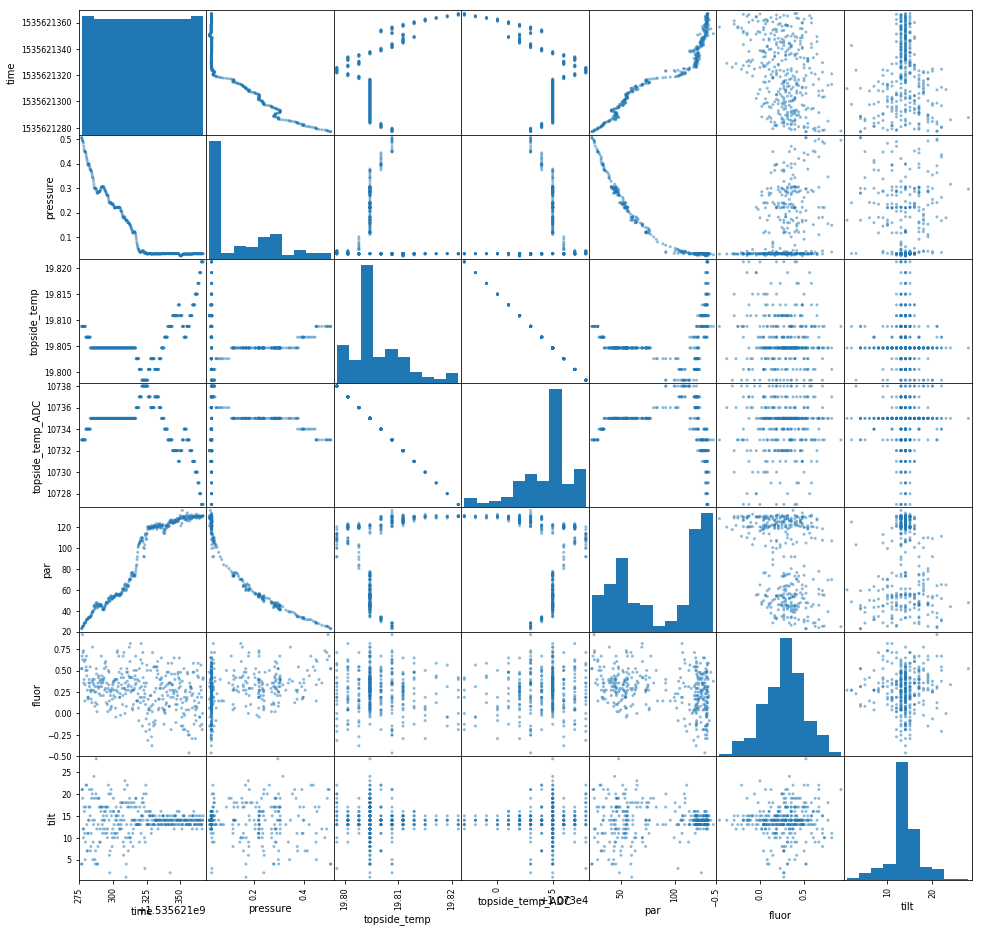

In [30]:
%matplotlib inline
pd.plotting.scatter_matrix(pro_data, figsize=(16, 16))

### Convert elapse time to datetime

In [31]:
from netCDF4 import num2date
pro_data['datetime'] =[num2date(x['time'],'seconds since 1970-1-1') for i,x in pro_data.iterrows()]

Profile data spells out the profile start time which is used to create the "datetime" variable

In [32]:
pro_data['datetime'][:10]

2    2018-08-30 09:27:57.000
3    2018-08-30 09:27:57.000
4    2018-08-30 09:27:57.250
5    2018-08-30 09:27:57.500
6    2018-08-30 09:27:57.750
7    2018-08-30 09:27:58.000
8    2018-08-30 09:27:58.250
9    2018-08-30 09:27:58.500
10   2018-08-30 09:27:58.750
11   2018-08-30 09:27:59.000
Name: datetime, dtype: datetime64[ns]

Bottom and Ice data start marking time from the "Unit_Start_Time" and "Unit_Release_Time" which should be incorporated into the config file

In [33]:
print(yaml.dump(IDNUMBER.config, default_flow_style=False))

UnitID: CodingTestData
Unit_Release_Time: '2018-8-30 10:00:00'
Unit_Start_Time: '2018-8-29 15:00:00'
fluor_cal:
  offset: 40
  slope: 0.020920502
par_cal:
  offset: 5458
  slope: 0.01415
sample_interval:
  bottom: 3600
  ice: 3600
  sst: 10800
topside_temp_cal:
  Acoef: 0.00121410745269167
  Bcoef: 0.000522254475008962
  Ccoef: 1.43969129191958e-06
underside_temp_cal:
  Acoef: 0.00121376381803238
  Bcoef: 0.000522637158831552
  Ccoef: 1.41820495016536e-06



In [34]:
bottom_data['datetime'] =[num2date(x['time'],'seconds since '+ str(IDNUMBER.config['Unit_Start_Time']) ) for i,x in bottom_data.iterrows()]

In [35]:
bottom_data['datetime']

0    2018-08-29 15:00:00
1    2018-08-29 16:00:00
2    2018-08-29 17:00:00
3    2018-08-29 18:00:00
4    2018-08-29 19:00:00
5    2018-08-29 20:00:00
6    2018-08-29 21:00:00
7    2018-08-29 22:00:00
8    2018-08-29 23:00:00
9    2018-08-30 00:00:00
10   2018-08-30 01:00:00
11   2018-08-30 02:00:00
12   2018-08-30 03:00:00
13   2018-08-30 04:00:00
14   2018-08-30 05:00:00
15   2018-08-30 06:00:00
16   2018-08-30 07:00:00
Name: datetime, dtype: datetime64[ns]

In [36]:
ice_data['datetime'] =[num2date(x['time'],'seconds since '+ str(IDNUMBER.config['Unit_Release_Time']) ) for i,x in ice_data.iterrows()]

In [37]:
ice_data['datetime']

0    2018-08-30 13:00:00
1    2018-08-30 14:00:00
2    2018-08-30 15:00:00
3    2018-08-30 16:00:00
4    2018-08-30 17:00:00
5    2018-08-30 18:00:00
6    2018-08-30 19:00:00
7    2018-08-30 20:00:00
8    2018-08-30 21:00:00
9    2018-08-30 22:00:00
10   2018-08-30 23:00:00
11   2018-08-31 00:00:00
12   2018-08-31 01:00:00
13   2018-08-31 02:00:00
14   2018-08-31 03:00:00
15   2018-08-31 04:00:00
16   2018-08-31 05:00:00
17   2018-08-31 06:00:00
18   2018-08-31 07:00:00
19   2018-08-31 08:00:00
20   2018-08-31 09:00:00
Name: datetime, dtype: datetime64[ns]

In [38]:
sst_data['datetime'] =[num2date(x['time'],'seconds since 1970-1-1') for i,x in sst_data.iterrows()]

In [39]:
sst_data['datetime']

0   2018-08-31 10:00:00
1   2018-08-31 10:20:11
2   2018-08-31 10:40:22
3   2018-08-31 11:04:19
4   2018-08-31 11:24:30
Name: datetime, dtype: datetime64[ns]

### Saving Data to be used in other software

simple as sending the pandas dataframe to csv

In [40]:
ice_data.to_csv('ice_data.csv')

### TODO:

+ ~~SST encode equations~~
+ output to csv, output specific plots
+ output as archive file (netcdf)
+ ~~input configuration file for coeficients to eliminate hard coding~~
+ input configuration file for netcdf output
+ Update Documentation and comments
+ ~~Collapse~~ 
 - ~~equations into one module of "equations"~~
 - ~~uint conversion into module~~
+ ~~prevent analysis of one type to work on different file~~
+ move pandas datetime calculations to class module
    - optionally reindex on time   
+ config file and report file to draw meta-data from
+ ~~output raw temperature probe data~~
+ email reminders when release is supposed to have let go and when data has started (AKUTAN)

+ ~~SBD - Stitch Routine~~